# Basic examples

In this notebook we will show how to compute power spectra with local or global line-of-sight, how to dump them to disk, etc.
You need to have installed **pypower** with:
```
python -m pip install git+https://github.com/cosmodesi/pypower#egg=pypower[extras]
```
(extras include sympy and numexpr for faster spherical harmonics)

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0,0), seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o,b in zip(offset,boxsize)]
        weights = rng.uniform(0.5, 1., size)
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

## High-level interface
Here we use the high-level interface, starting from the catalogs directly.

In [4]:
# Compute the cross-power spectrum multipoles of order (0, 2, 4), with 10 bins between 0 and 0.2
# using local line-of-sight, box physical size of 2000, mesh size of 256^3, TSC assignment scheme,
# interlacing correction (2nd order)
# los can be None (local) or any box axis ('x', 'y', 'z') or 3-vector
# Input positions, weights are gathered (not MPI-scattered), so we tell CatalogFFTPower
# to take positions and weights from rank 0 (mpiroot = 0)
# position_type is 'xyz' because input positions are (3, N); in case positions are (N, 3), pass position_type='pos'
# weights can be ommitted if constant (1)
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         data_positions2=data_positions2, data_weights2=data_weights2,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz', mpiroot=0)
# Note that you can also provide single data/randoms catalogs (auto-correlation),
# no randoms (uniform selection function), no weights (assumed unity)

[000000.11]  05-05 01:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   499.99200437  499.99818966], dtype=float64).
[000000.12]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000000.16]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000000.16]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000000.22]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000000.22]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000000.26]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000000.31]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000000.31]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

Shot noise is 0.0000.
Normalization is 0.0553.


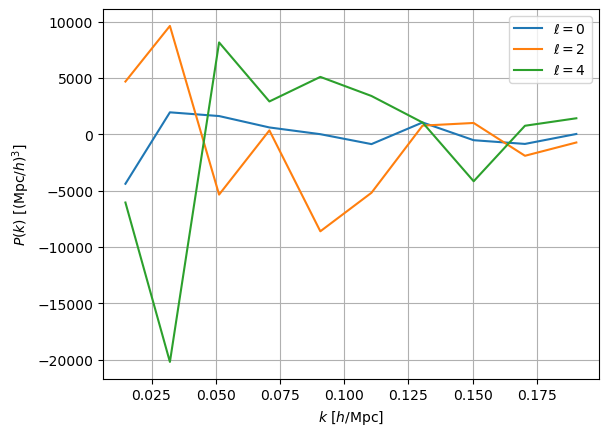

In [5]:
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    # Calling poles() removes shotnoise for ell == 0 by default;
    # Pass remove_shotnoise = False if you do not want to;
    # See get_power() for all arguments
    ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

In [6]:
# One can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    result = CatalogFFTPower.load(fn)
    print(result.poles.ells)
# One can also only save multipoles
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.poles.save(fn)
    # And reload the result
    poles = PowerSpectrumStatistics.load(fn)
    print(poles.ells, type(poles))
# One can also export result as .txt (WARNING: this does not save all "poles" attributes, so there is not "load_txt" method)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    print('\n### real ###\n')
    # See get_power() for all arguments
    result.poles.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=False)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])
    # Let's check saved result
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[3], result.poles(ell=0, complex=False), equal_nan=True)
    # Saving full complex numbers
    print('\n### complex ###\n')
    result.poles.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=True)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])
    # Let's check saved result
    tmp = np.loadtxt(fn, unpack=True, dtype=np.complex_)
    assert np.allclose(tmp[4], result.poles(ell=2, complex=True), equal_nan=True)

[000003.67]  05-05 01:46  CatalogFFTPower              INFO     Saving /tmp/tmp1av5na6k/tmp.npy.
[000003.68]  05-05 01:46  CatalogFFTPower              INFO     Loading /tmp/tmp1av5na6k/tmp.npy.
(0, 2, 4)
[000003.68]  05-05 01:46  PowerSpectrumMultipoles      INFO     Saving /tmp/tmpjdcpk4__/tmp.npy.
[000003.68]  05-05 01:46  PowerSpectrumStatistics      INFO     Loading /tmp/tmpjdcpk4__/tmp.npy.
(0, 2, 4) <class 'pypower.fft_power.PowerSpectrumMultipoles'>

### real ###

[000003.69]  05-05 01:46  PowerSpectrumMultipoles      INFO     Saving /tmp/tmpcopj8x4n/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# autocorr = False
# data_size1 = 10000
# data_size2 = 10000
# sum_data_weights1 = 7.493566915134e+03
# sum_data_weights2 = 7.496122387445e+03
# randoms_size1 = 50000
# randoms_size2 = 50000
# sum_randoms_weights1 = 3.750816478469e+04
# sum_randoms_weights2 = 3.745845068475e+04
# shifted_size1 = 0
# shifted_size2 = 0
# sum_shifted_weights1 = 0.000000000000e+00
# sum_shift

### Line-of-sight

[000003.75]  05-05 01:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000003.75]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000003.82]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000003.82]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000003.90]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000003.90]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000003.94]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000004.00]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000004.01]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

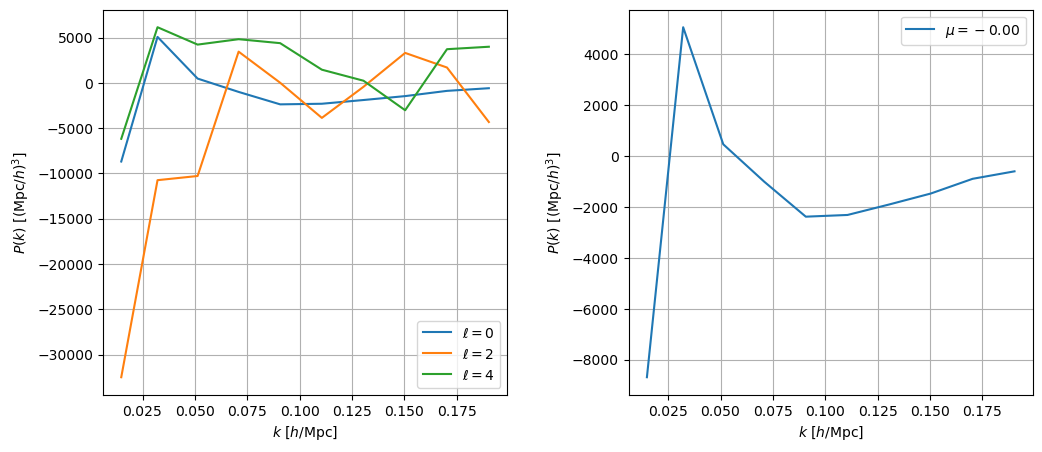

[000007.48]  05-05 01:46  PowerSpectrumWedges          INFO     Saving /tmp/tmp95ckhgt0/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# autocorr = True
# data_size1 = 10000
# data_size2 = 10000
# sum_data_weights1 = 7.493566915134e+03
# sum_data_weights2 = 7.493566915134e+03
# randoms_size1 = 50000
# randoms_size2 = 50000
# sum_randoms_weights1 = 3.750816478469e+04
# sum_randoms_weights2 = 3.750816478469e+04
# shifted_size1 = 0
# shifted_size2 = 0
# sum_shifted_weights1 = 0.000000000000e+00
# sum_shifted_weights2 = 0.000000000000e+00
# los_type = global
# los = [1.000000000000e+00 0.000000000000e+00 0.000000000000e+00]
# nmesh = [128 128 128]
# boxsize = [2.000000000000e+03 2.000000000000e+03 2.000000000000e+03]
# boxcenter = [1.499992081204e+03 5.000003609569e+02 5.000219603290e+02]
# resampler1 = tsc
# resampler2 = tsc
# interlacing1 = 2
# interlacing2 = 2
# shotnoise = 1.245954218613e+05


In [7]:
# By default (above), line-of-sight is 'firstpoint'
# Compute the power spectrum, using 'endpoint' line-of-sight
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los='endpoint', position_type='xyz', mpiroot=0)

# Compute the power spectrum, using 'x' line-of-sight
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los='x', position_type='xyz', mpiroot=0)
# In addition to "poles", one has access to "wedges"

poles = result.poles
wedges = result.wedges
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for ill, ell in enumerate(poles.ells):
    # Shot noise removed
    lax[0].plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
# With global line-of-sight, we also have wedges
for imu, mu in enumerate(wedges.muavg):
    # Shot noise removed
    lax[1].plot(*wedges(mu=mu, return_k=True, complex=False), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

# One can also export result as .txt (WARNING: this does not save all "wedges" attributes, so there is not "load_txt" method)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    # See get_power() for all arguments
    result.wedges.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=False)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])
    # Let's check saved result
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[5], result.wedges(mu=result.wedges.modeavg(axis=1, method='mid')[0], complex=False), equal_nan=True)

### Residual

[000007.53]  05-05 01:46  CatalogFFTResidual           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000007.54]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000007.62]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000007.62]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000007.71]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000007.71]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000007.76]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000007.85]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000007.85]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

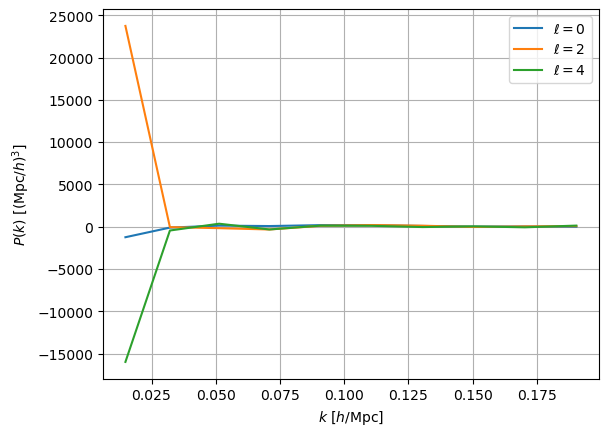

In [8]:
# "residual" estimator, computing (D - R) * R (in case shifted catalog is provided, this is (D - S) * R)
from pypower import CatalogFFTResidual
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result_residual = CatalogFFTResidual(data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                                     los=None, position_type='xyz', mpiroot=0)
poles = result_residual.poles
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    # Shot noise removed
    ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax.grid(True)
ax.legend()
plt.show()

### Reconstruction

In [9]:
# In case of reconstruction, using shifted catalogs random catalogs (here we just use the same)
# This will compute the power spectrum of D - S, normalized using R.
# See https://github.com/cosmodesi/pyrecon/blob/main/nb/e2e_examples.ipynb
shifted_positions1, shifted_weights1 = randoms_positions1, randoms_weights1
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         shifted_positions1=shifted_positions1, shifted_weights1=shifted_weights1,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz', mpiroot=0)

[000010.64]  05-05 01:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000010.64]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000010.73]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000010.73]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000010.81]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000010.81]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000010.85]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000010.92]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000010.92]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

## Catalog mesh
Internally, CatalogFFTPower build one (two if cross-power) CatalogMesh instances (with same mesh) and pass them to MeshFFTPower.

In [10]:
# Here we let it choose the box size
mesh1 = CatalogMesh(data_positions=data_positions1, data_weights=data_weights1,
                    randoms_positions=randoms_positions1, randoms_weights=randoms_weights1,
                    interlacing=2, boxsize=None, nmesh=128, resampler='tsc', position_type='xyz', mpiroot=0)
# Here again, for uniform selection function, just do not provide randoms
# Here we provide global line-of-sight and mu-edges
muedges = np.linspace(-1., 1., 4)
result = MeshFFTPower(mesh1, edges=(kedges, muedges), los='z')

[000013.05]  05-05 01:46  MeshFFTPower                 INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[1999.94622506 1999.94622506 1999.94622506], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000013.05]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000013.13]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000013.13]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000013.21]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000013.21]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000013.25]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000013.32]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000013.32]  05-05 01:46  CatalogMesh                  INFO   

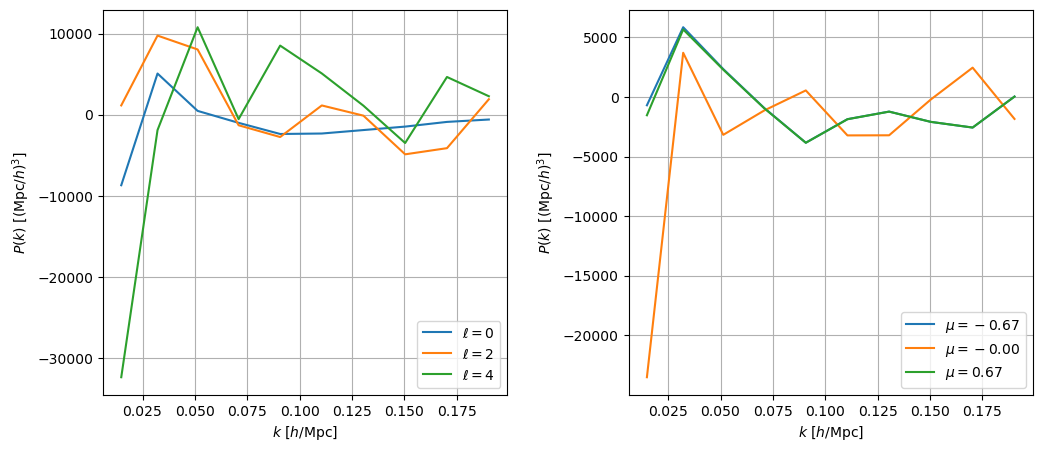

In [11]:
poles = result.poles
wedges = result.wedges
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for ill, ell in enumerate(poles.ells):
    # Shot noise removed
    lax[0].plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
# With global line-of-sight, we also have wedges
for imu, mu in enumerate(wedges.muavg):
    # Shot noise removed
    lax[1].plot(*wedges(mu=mu, return_k=True, complex=False), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

## Rebinning
We provide methods to rebin power spectrum estimation accurately, i.e. taking the number of $k$-modes into account.

In [12]:
poles2 = poles[::2]
print('Initial k-modes {}.'.format(poles.kavg))
print('After rebinning {}.'.format(poles2.kavg))

Initial k-modes [0.01483472 0.03215042 0.05129251 0.07087069 0.09070497 0.11058973
 0.13047672 0.15038655 0.1703575  0.19034838].
After rebinning [0.0300727  0.06426886 0.10259729 0.14184564 0.18145079].


In [13]:
# Note that one can remove some bins such that the rebinning factor divides the shape
# Here we remove the last bin of the second axis before rebinning
wedges2 = wedges[::2,:-1:2]
print('Initial k-modes {}, mu-modes {}.'.format(wedges.kavg, wedges.muavg))
print('After rebinning {}, {}.'.format(wedges2.kavg, wedges2.muavg))
# Usually, one would like to remove the remainder last bins
factor = 6
rebinned = poles[:(poles.shape[0] // factor) * factor:factor]

Initial k-modes [0.01483472 0.03215042 0.05129251 0.07087069 0.09070497 0.11058973
 0.13047672 0.15038655 0.1703575  0.19034838], mu-modes [-6.66912929e-01 -1.21998220e-04  6.66790655e-01].
After rebinning [0.03008018 0.06428116 0.10260415 0.14183939 0.18144892], [-0.33320194].


In [14]:
# You can also select some range
kavg, muavg = wedges.kavg, wedges.muavg
print('Initially k in [{}, {}], mu in [{}, {}].'.format(kavg.min(), kavg.max(), muavg.min(), muavg.max()))
wedges.select((0, 0.07), (-1., 0))
kavg, muavg = wedges.kavg, wedges.muavg
print('After selection k in [{}, {}], mu in [{}, {}].'.format(kavg.min(), kavg.max(), muavg.min(), muavg.max()))

Initially k in [0.014834716845057945, 0.1903483846340751], mu in [-0.666912929343983, 0.6667906545268477].
After selection k in [0.01483394075943182, 0.05131403914262816], mu in [-0.6684573673434536, -0.0010927842092681777].


### Combining power spectrum estimation in two regions (typically N & S)

[000014.37]  05-05 01:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000014.37]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000014.44]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000014.44]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000014.51]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000014.51]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000014.56]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000014.62]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000014.62]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

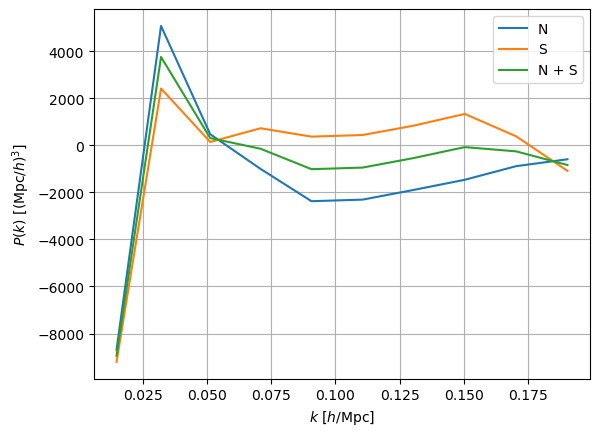

In [15]:
poles_N = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                          randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                          edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                          los='endpoint', position_type='xyz', mpiroot=0).poles
poles_S = CatalogFFTPower(data_positions1=data_positions2, data_weights1=data_weights2,
                          randoms_positions1=randoms_positions2, randoms_weights1=randoms_weights2,
                          edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                          los='endpoint', position_type='xyz', mpiroot=0).poles

# To average the power spectra weighted by their wnorm:
poles_NS = poles_N + poles_S
# Which is equivalent to:
from pypower import PowerSpectrumMultipoles
poles_NS_avg = PowerSpectrumMultipoles.average([poles_N, poles_S], weights=[1., 1.])
assert np.allclose(poles_NS.power, poles_NS_avg.power)

ax = plt.gca()
ax.plot(*poles_N(ell=0, return_k=True, complex=False), label='N')
ax.plot(*poles_S(ell=0, return_k=True, complex=False), label='S')
ax.plot(*poles_NS(ell=0, return_k=True, complex=False), label='N + S')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax.grid(True)
ax.legend()
plt.show()

### Redshift weights
One may want to compute the auto-power spectrum of a sample, but with two different weights. To properly account for the shot noise, one should provide only data_positions1, not data_positions2.

In [16]:
# Computing the monopole, with two set of weights (notice data_weights2)
poles_0 = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1, data_weights2=data_weights2,
                          randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                          edges=kedges, ells=0, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                          los='endpoint', position_type='xyz', mpiroot=0).poles

# Computing the quadrupole, with other two set of weights (notice data_weights2)
poles_2 = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1, data_weights2=2. * data_weights2,
                          randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                          edges=kedges, ells=2, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                          los='endpoint', position_type='xyz', mpiroot=0).poles

# Then you can combine the two measurements together
poles_02 = PowerSpectrumMultipoles.concatenate_proj(poles_0, poles_2)
# Checks
assert np.allclose(poles_02(ell=0), poles_0(ell=0))
assert np.allclose(poles_02(ell=2), poles_2(ell=2))

[000018.67]  05-05 01:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000018.67]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000018.74]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000018.74]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000018.81]  05-05 01:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000018.81]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000018.84]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000018.91]  05-05 01:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000018.91]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

## MPI
**pypower** is MPI-parallelized. Below is an example script.

In [17]:
base_dir = '_tests'
utils.mkdir(base_dir)

In [18]:
%%file '_tests/script.py'

import os

import numpy as np
import fitsio

from pypower import CatalogFFTPower, mpi, setup_logging

# To activate logging
setup_logging()

base_dir = os.path.join('..', 'pypower', 'tests', 'catalog')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')

mpicomm = mpi.COMM_WORLD
kedges = np.linspace(0, 0.2, 41)

# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=('Position', 'WEIGHT_FKP'), ext=1):
    csize = fitsio.FITS(fn)[ext].get_nrows()
    start, stop = mpicomm.rank * csize // mpicomm.size, (mpicomm.rank + 1) * csize // mpicomm.size
    tmp = fitsio.read(fn, ext=ext, columns=columns, rows=range(start, stop))
    return [tmp[col] for col in columns]
    # Alternatively, you can use mpytools
    #from mpytools import Catalog
    #catalog = Catalog.read(fn, ext=ext, mpicomm=mpicomm)
    #return [catalog[col] for col in columns]

data_positions, data_weights = read(data_fn)
mpiroot = None # input positions/weights scattered on all processes
"""
# Alternatively, if you do not want to read catalog on process 0:
mpiroot = 0
# We read catalog on a single process
if mpicomm.rank == mpiroot:
    file = fitsio.read(data_fn)
    data_positions, data_weights = file['Position'], file['WEIGHT_FKP']
else:
    data_positions, data_weights = None, None
"""
power = CatalogFFTPower(data_positions1=data_positions, data_weights1=data_weights, nmesh=128, boxsize=600., boxcenter=0.,
                        resampler='tsc', interlacing=3, ells=(0, 2, 4), los='x', edges=(kedges, np.linspace(-1., 1., 5)),
                        position_type='pos', mpicomm=mpicomm, mpiroot=mpiroot, dtype='f4')

base_dir = '_tests'
fn = os.path.join(base_dir, 'power.npy')
power.save(fn)

Overwriting _tests/script.py


In [19]:
%%bash
mpiexec -np 4 python _tests/script.py

[000000.07]  05-05 01:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[600. 600. 600.], boxcenter=[0. 0. 0.], dtype=float32).
[000000.08]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000000.17]  05-05 01:46  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000000.17]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 3.
[000000.20]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000000.28]  05-05 01:46  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000000.33]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000000.41]  05-05 01:46  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000000.47]  05-05 01:46  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000000.47]  05-

In [20]:
!ls -l _tests

total 20
-rw-r--r-- 1 adematti idphp 16201 mai    5 01:46 power.npy
-rw-r--r-- 1 adematti idphp  1725 mai    5 01:46 script.py


In [21]:
power = CatalogFFTPower.load(os.path.join(base_dir, 'power.npy'))
poles = power.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise))
print('Normalization is {:.4f}.'.format(poles.wnorm))

[000023.84]  05-05 01:46  CatalogFFTPower              INFO     Loading _tests/power.npy.
Shot noise is 1005.1561.
Normalization is 213.7897.


## Plotting
There is a simple plotting function for basic plots.

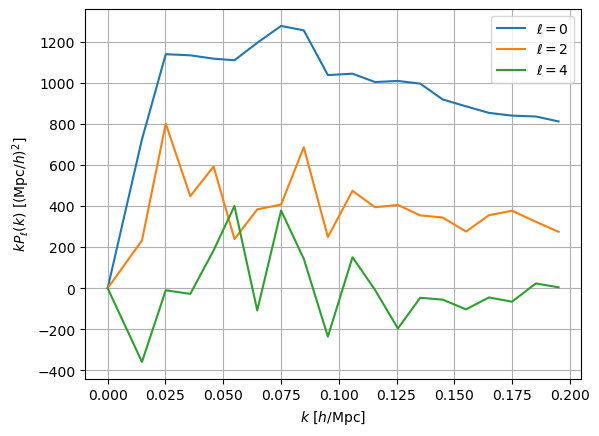

In [22]:
poles[::2].plot(show=True);

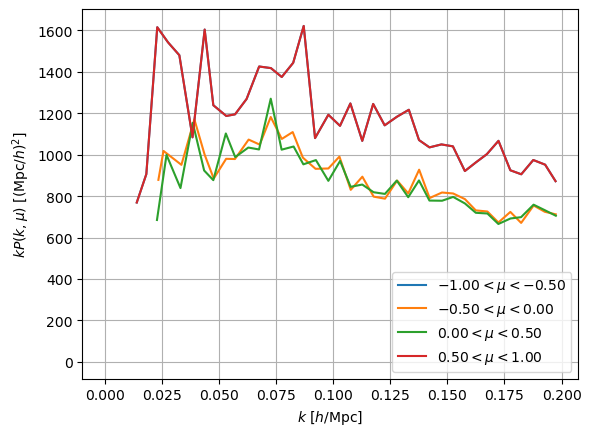

In [23]:
power.wedges.plot(show=True);

## Correlation function
One can estimate the correlation function in a box, as shown below.

[000024.41]  05-05 01:46  CatalogFFTCorr               INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[600. 600. 600.], boxcenter=[0. 0. 0.], dtype=float32).
[000024.42]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000024.55]  05-05 01:46  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000024.55]  05-05 01:46  CatalogMesh                  INFO     Running interlacing at order 3.
[000024.58]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000024.70]  05-05 01:46  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000024.75]  05-05 01:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000024.86]  05-05 01:46  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000024.93]  05-05 01:46  CatalogFFTCorr               INFO     Done painting catalog 1 to mesh.
[000024.93]  05-

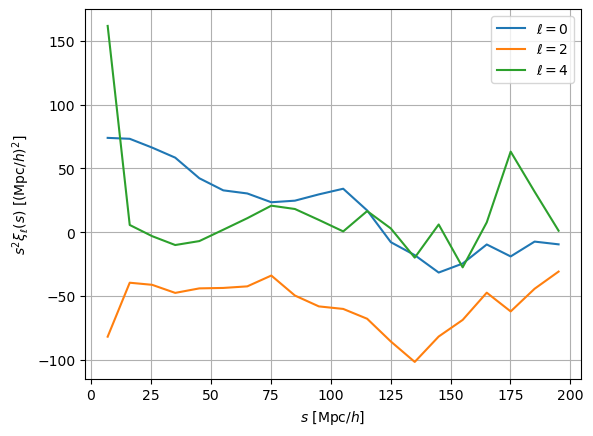

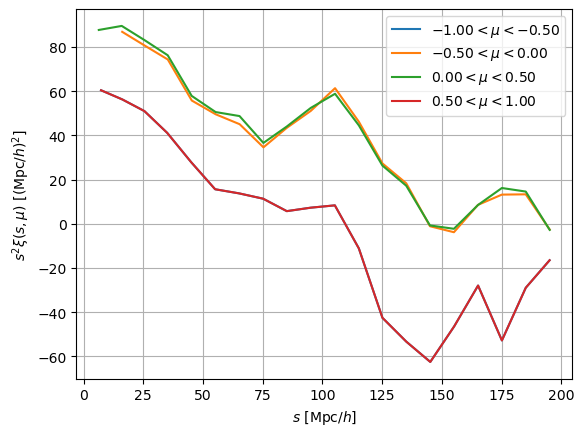


### real ###

[000025.65]  05-05 01:46  CorrelationFunctionMultipoles INFO     Saving /tmp/tmp6zhg0vbp/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# autocorr = True
# data_size1 = 214892
# data_size2 = 214892
# sum_data_weights1 = 214892.
# sum_data_weights2 = 214892.
# randoms_size1 = 0
# randoms_size2 = 0
# sum_randoms_weights1 = 0.
# sum_randoms_weights2 = 0.
# shifted_size1 = 0
# shifted_size2 = 0
# sum_shifted_weights1 = 0.
# sum_shifted_weights2 = 0.
# los_type = global
# los = [1. 0. 0.]
# nmesh = [128 128 128]
# boxsize = [600. 600. 600.]
# boxcenter = [0. 0. 0.]
# resampler1 = tsc
# resampler2 = tsc
# interlacing1 = 3
# interlacing2 = 3
# shotnoise = 9.75909759


In [24]:
import fitsio

from pypower import CatalogFFTCorr, mpi

base_dir = os.path.join('..', 'pypower', 'tests', 'catalog')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')

mpicomm = mpi.COMM_WORLD

# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=('Position', 'WEIGHT_FKP'), ext=1):
    csize = fitsio.FITS(fn)[ext].get_nrows()
    start, stop = mpicomm.rank * csize // mpicomm.size, (mpicomm.rank + 1) * csize // mpicomm.size
    tmp = fitsio.read(fn, ext=ext, columns=columns, rows=range(start, stop))
    return [tmp[col] for col in columns]
    # Alternatively, you can use mpytools
    #from mpytools import Catalog
    #catalog = Catalog.read(fn, ext=ext, mpicomm=mpicomm)
    #return [catalog[col] for col in columns]

data_positions, data_weights = read(data_fn)

sedges = np.linspace(0., 200., 21)
corr = CatalogFFTCorr(data_positions1=data_positions, data_weights1=data_weights, nmesh=128, boxsize=600., boxcenter=0.,
                      resampler='tsc', interlacing=3, ells=(0, 2, 4), los='x', edges=(sedges, np.linspace(-1., 1., 5)),
                      position_type='pos', mpicomm=mpicomm, mpiroot=None, dtype='f4')

corr.poles.plot(show=True);
corr.wedges.plot(show=True);

with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    print('\n### real ###\n')
    # See get_power() for all arguments
    corr.poles.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=False)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])

In [25]:
# Rebinning operations similar to the power spectrum case can be applied
poles = corr.poles
poles2 = poles[::2]
print('Initial s-modes {}.'.format(poles.savg))
print('After rebinning {}.'.format(poles2.savg))

Initial s-modes [  6.93564904  16.13805655  25.46957885  35.11918094  45.18073076
  55.17503557  65.20259808  75.22190951  85.06760981  95.06160295
 105.22504746 115.22409148 125.10563618 135.0753902  145.06784636
 155.07864048 165.12485526 175.10741161 185.09642332 195.10204617].
After rebinning [ 15.24750099  32.04805984  51.15143843  70.89640641  90.72462509
 110.61080732 130.50894294 150.43919934 170.38762319 190.34881992].
